In [35]:
import time
import pickle
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

import copy
from sklearn.ensemble import ExtraTreesRegressor

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, he_normal, he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

from matplotlib.legend_handler import HandlerLine2D

In [11]:
class Process:
    def __init__(self, 
                 X_train, X_test, X_val, y_train, y_test, y_val, 
                 imputer='mean', 
                 minmaxrange=(-1,1), 
                 standardize_X=True,
                 standardize_y=True,
                 robust_range=(10, 90),
                ):
        self.y_process = []
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.y_val = y_val.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.X_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)
            self.X_val[:] = imputer.transform(self.X_val)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        self.X_val[:] = self.X_minmaxscaler.transform(self.X_val)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = self.y_minmaxscaler.transform(self.y_train)
        self.y_test[:] = self.y_minmaxscaler.transform(self.y_test)
        self.y_val[:] = self.y_minmaxscaler.transform(self.y_val)
        self.y_process.append(self.minmaxscale_Y_inverse)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def robustscale_X(self):
        self.X_robust_scaler.fit(self.X_train)
        self.X_train[:] = self.X_robust_scaler.transform(self.X_train)
        self.X_test[:] = self.X_robust_scaler.transform(self.X_test)
        self.X_val[:] = self.X_robust_scaler.transform(self.X_val)
        return self
    
    def robustscale_X_inverse(self, data):
        return self.X_robust_scaler.inverse_transform(data)
    
    def robustscale_Y(self, inverse=False):
        self.y_robust_scaler.fit(self.y_train)
        self.y_train[:] = self.y_robust_scaler.transform(self.y_train)
        self.y_test[:] = self.y_robust_scaler.transform(self.y_test)
        self.y_val[:] = self.y_robust_scaler.transform(self.y_val)
        self.y_process.append(self.robustscale_Y_inverse)
        return self
    
    def robustscale_Y_inverse(self, data): # data is in 1d array
        return self.y_robust_scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        self.X_val[:] = self.skewer_X.transform(self.X_val)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        self.y_val = self.skewer_y.transform(self.y_val)
        self.y_process.append(self.skew_y_inverse)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.X_val, self.y_train.flatten(), self.y_test.flatten(), self.y_val.flatten()      

In [34]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': np.mean(np.abs((y_test - y_pred)/y_test)) * 100,
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]:,.3f}')
    return res


def predict(model, model_name, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    if len(pred_train.shape) == 2 and pred_train.shape[1] == 1:
        pred_train = pred_train.flatten()
        pred_test = pred_test.flatten()
    return {
        'res': {
            'train': get_metrics(y_train, pred_train, X_train.shape[1]),
            'test': get_metrics(y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def output_metrics(model, data, process, with_val=True):
    if with_val:  
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],
                       data['X_val'],
                       data['y_val'])
    else:
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],  
                       data['X_test'],
                       data['y_test'])

    y_actual_train_back = res['actual']['train']
    y_pred_train_back = res['predictions']['train']
    y_actual_test_back = res['actual']['test']
    y_pred_test_back = res['predictions']['test']
    
    print_sorted_actual_to_predicted_graphs(
        y_actual_train_back,
        y_pred_train_back,
        y_actual_test_back,
        y_pred_test_back)

    if process and process.y_process:
        for apply_function in reversed(process.y_process):
            y_actual_train_back = apply_function(y_actual_train_back)
            y_pred_train_back = apply_function(y_pred_train_back)
            y_actual_test_back = apply_function(y_actual_test_back)
            y_pred_test_back = apply_function(y_pred_test_back)

        print_metrics('train', y_actual_train_back, y_pred_train_back, data['X_train'].shape[1])
        print_metrics('test', y_actual_test_back, y_pred_test_back, data['X_test'].shape[1])
        print_sorted_actual_to_predicted_graphs(
            y_actual_train_back,
            y_pred_train_back,
            y_actual_test_back,
            y_pred_test_back, print_log=True)


def print_graphs(actual, predicted, title, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='revenue actual')
    plt.plot(x, res_df['predicted'], label='revenue predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.xlabel('movie')
    plt.ylabel('revenue')
    plt.title(title)
    plt.legend()
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(train_real, train_pred, test_real, test_pred, print_log=False):
    if print_log:
        print_graphs(train_real, train_pred, 'train data: log scale', print_log=True)
        print_graphs(test_real, test_pred, 'validation data: log scale', print_log=True)
    print_graphs(train_real, train_pred, 'train data')
    print_graphs(test_real, test_pred, 'validation data')
    
# -----------------------------------------

def get_data():
    with open('proc_data_001.pickle', 'rb') as handle:
        d = pickle.load(handle)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        return X_train, y_train, X_test, y_test

In [12]:
with open('processed/dataset_all_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open('processed/dataset_all_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

In [21]:
def get_train_test_mape(model, data, process):
    res = predict(model, "DT", 
               data['X_train'],  
               data['y_train'],  
               data['X_test'],
               data['y_test'])
    for apply_function in reversed(process.y_process):
        y_actual_train_back = apply_function(res['actual']['train'])
        y_pred_train_back = apply_function(res['predictions']['train'])
        y_actual_test_back = apply_function(res['actual']['test'])
        y_pred_test_back = apply_function(res['predictions']['test'])
    train_mape = get_metrics(y_actual_train_back, y_pred_train_back, data['X_train'].shape[1])['mae']
    test_mape = get_metrics(y_actual_test_back, y_pred_test_back, data['X_train'].shape[1])['mae']
    return train_mape, test_mape

In [84]:
def print_results(name, param, train, test):
    print('train', train)
    print('test', test)

    line1, = plt.plot(param, train, 'b', label="Train MAE")
    line2, = plt.plot(param, test, 'r', label="Test MAE")
    plt.legend(handler_map={line1: HandlerLine2D()})
    plt.ylabel('MAE')
    plt.xlabel(name)
    plt.show()

In [ ]:
train_results = []
test_results = []
parameter = [70, 80, 90]
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=p,
        criterion='mae',
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

train [19860324.132334735, 19764416.923731267, 19803952.692101013]
test [41610209.9957954, 41684374.83803457, 41778079.1883732]


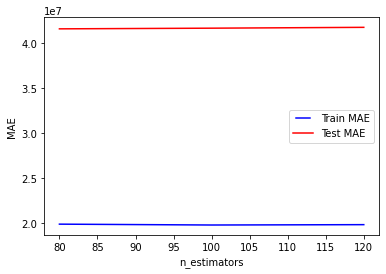

In [43]:
print_results('n_estimators', train_results, test_results)

In [ ]:
train_results = []
test_results = []
parameter = [4,5,7,8]
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=80,
        max_depth=p,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

train [51931466.97708544, 41536137.82640604, 29526122.06422774]
test [52573073.180340685, 42748251.018912606, 41914310.87465603]


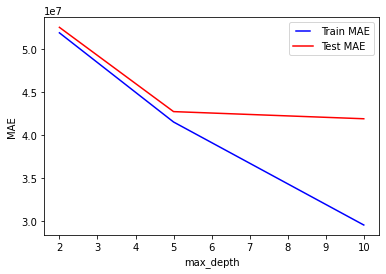

In [62]:
print_results('max_depth', parameter, train_results, test_results)

In [72]:
train_results = []
test_results = []
parameter = np.linspace(0.0001, 0.002, 5)
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=80,
        max_depth=40,
        min_samples_split=p,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

0.0001


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   57.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


0.000575


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   55.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


0.00105


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   56.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


0.001525


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   55.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


0.002


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   55.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


In [85]:
train_results = []
test_results = []
parameter = np.linspace(0.0001, 0.002, 5)
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=80,
        max_depth=40,
        min_samples_split=0.001,
        min_samples_leaf=p,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

0.0001


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   54.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


0.000575


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   51.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


0.00105


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   50.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


0.001525


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   49.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


0.002


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   48.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


train [21698584.742276385, 27078158.26686779, 31405038.376722068, 33789501.746121205, 34748889.45956734]
test [41455146.498783395, 41220407.83108124, 41299326.080305666, 41690015.0384301, 41511555.41702922]


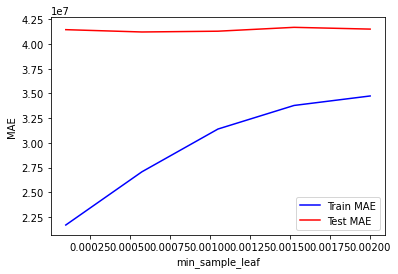

In [86]:
print_results('min_sample_leaf', parameter, train_results, test_results)

In [ ]:
train_results = []
test_results = []
parameter = np.linspace(0.1, 0.99, 10)
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=80,
        max_depth=40,
        min_samples_split=0.001,
        min_samples_leaf=0.0005,
        bootstrap=True,
        max_samples=p,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

best p:  0.9
train [42191240.635504924, 38612465.94160672, 36290027.7094341, 33901611.71867487, 32057003.433396757, 30427429.02234338, 28744922.6715217, 27250475.93643616, 26189671.602306567]
test [44210071.681306034, 42985780.52813648, 42072826.612026416, 41731563.53736941, 41591382.33264724, 41810075.346993946, 41673733.14713417, 42120428.28988185, 41567576.55369028]


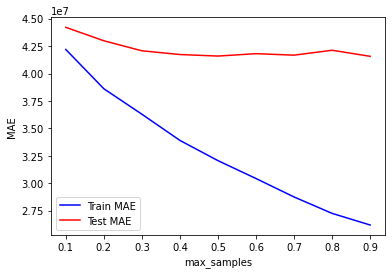

In [95]:
print('best p: ', parameter[np.argmin([test_results])])
print_results('max_samples', parameter[:-1], train_results, test_results)

In [102]:
train_results = []
test_results = []
parameter = [0.85, 0.9, 0.95]
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=80,
        max_depth=40,
        min_samples_split=0.001,
        min_samples_leaf=0.0005,
        bootstrap=True,
        max_samples=0.5,
        max_features=p,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

0.85


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


0.9


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   20.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


0.95


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    0.0s finished


best p:  0.95
train [32330923.20767775, 32210056.612700302, 32239207.6977215]
test [42273315.535896555, 41689975.42118894, 41679717.205032766]


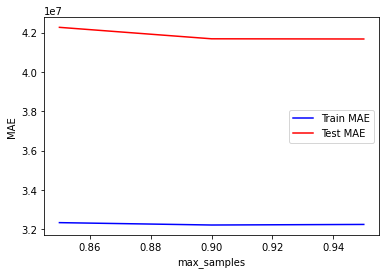

In [103]:
print('best p: ', parameter[np.argmin([test_results])])
print_results('max_samples', parameter, train_results, test_results)

In [114]:
train_results = []
test_results = []
parameter = [9, 12, 15, 18, 21]
for p in parameter:
    print(p)
    model = RandomForestRegressor(
        n_estimators=40,
        max_depth=p,
        min_samples_split=0.001,
        min_samples_leaf=0.0005,
        bootstrap=True,
        max_samples=0.95,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
        verbose=1,
    )
    model.fit(data['X_train'], data['y_train'])
    result = get_train_test_mape(model, data, process)
    train_results.append(result[0])
    test_results.append(result[1])

9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   22.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


12


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   41.0s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   42.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


15


[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   25.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   27.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   24.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   24.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    0.0s finished


best p:  15
train [33024872.86737259, 29106996.66304824, 27134914.34017526, 26105129.815611284, 25733747.88166742]
test [41494897.462920524, 42138884.166427575, 40913067.15688732, 41283509.715606526, 41557952.662228376]


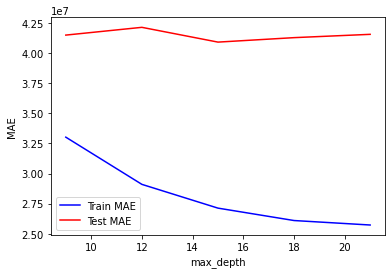

In [115]:
print('best p: ', parameter[np.argmin([test_results])])
print_results('max_depth', parameter, train_results, test_results)